In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [24]:

def mutiplyGauss (m1 , s1 , m2 , s2):
    s = 1 / (1/s1 + 1/s2)
    m = (m1/s1 + m2/s2) * s
    return m, s


def divideGauss (m1 , s1 , m2 , s2):
    m, s = mutiplyGauss(m1 , s1 , m2 , -s2)
    return m, s

def truncGaussMM (a, b, m0 , s0):
    a_scaled , b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = stats.truncnorm.mean(a_scaled , b_scaled , loc=m0 , scale=np.sqrt(s0))
    s = stats.truncnorm.var(a_scaled , b_scaled , loc=m0 , scale=np.sqrt(s0))
    return m, s

In [3]:
# # P(t|y)
# if y == 1:
#     mu_t_y, sigma_t_y =  truncGaussMM(0, np.inf, mu_5, sigma_5)
# elif y == -1:
#     mu_t_y, sigma_t_y =  truncGaussMM(-np.inf, 0 , mu_5, sigma_5)


# # M_8
# mu_8, sigma_8 = divideGauss(mu_t_y, sigma_t_y, mu_5, sigma_5)


# # p(s1, s2| t)
# mu_s, sigma_s = mutiplyGauss(mu_s1, sigma_s1, mu_s2, sigma_s2)
# mu, sigma = mutiplyGauss(mu_8, sigma_8, mu_s, sigma_s)

# print(mu)
# print(sigma)


# x_axis = np.arange(0, 40, 1)
# plt.plot(x_axis, stats.norm.pdf(x_axis, mu, np.sqrt(sigma)))
# plt.show()

In [4]:
serie_A_data = pd.read_csv('Q5/SerieA.csv', delimiter=',')
print(serie_A_data.head())

   yyyy-mm-dd  HH:MM     team1     team2  score1  score2
0  2018-08-18  18:00    Chievo  Juventus       2       3
1  2018-08-18  20:30     Lazio    Napoli       1       2
2  2018-08-19  18:00    Torino      Roma       0       1
3  2018-08-19  20:30  Sassuolo     Inter       1       0
4  2018-08-19  20:30     Parma   Udinese       2       2


In [5]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point
    A = np.array([[1, -1]])
    
    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y==1:
            t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y==-1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
            
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

In [35]:
num_samples = 500
mu_0 = 25.0
sigma_0 = 40.0
beta_inv = 1 #2/np.sqrt(sigma_0)

unique_teams = pd.concat([serie_A_data['team1'], serie_A_data['team2']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, sigma_0)
})

skills_df_FACTOR = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : mu_0
})

skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}
skills_history_FACTOR = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(serie_A_data.iterrows(), total=serie_A_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    if score1 == score2:
        continue
    
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    y = 1 if score1 > score2 else -1

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]

    mu1 = skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team2, 'sigma'].values[0]

    mt, st = truncGaussMM(0, np.inf, mu1-mu2 , beta_inv + sigma1 + sigma2) if y==1 else  truncGaussMM(-np.inf, 0, mu1-mu2 , beta_inv + sigma1 + sigma2)
    
    m6, s6 = divideGauss(mt , st , mu1-mu2 , beta_inv + sigma1 + sigma2)
    
    m71, m72 = m6 + mu2, -m6 + mu1
    s71, s72 = beta_inv + sigma2 + s6, beta_inv + sigma1 + s6

    m1_star, s1_star = mutiplyGauss(mu1, sigma1, m71, s71)
    m2_star, s2_star = mutiplyGauss(mu2, sigma2, m72, s72)
    
    s_1 = np.random.normal(m1_star, s1_star)
    s_2 = np.random.normal(m2_star, s2_star)

    skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team1, 'mu'] = m1_star
    skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team1, 'sigma'] = s1_star
    skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team2, 'mu'] = m2_star
    skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team2, 'sigma'] = s2_star
    skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team1, 's'] = s_1
    skills_df_FACTOR.loc[skills_df_FACTOR['team'] == team2, 's'] = s_2
    skills_history_FACTOR[team1].append((m1_star, s1_star))
    skills_history_FACTOR[team2].append((m2_star, s2_star))



Processing Matches:   0%|          | 0/380 [00:00<?, ?match/s]

Processing Matches: 100%|██████████| 380/380 [03:00<00:00,  2.11match/s]


c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

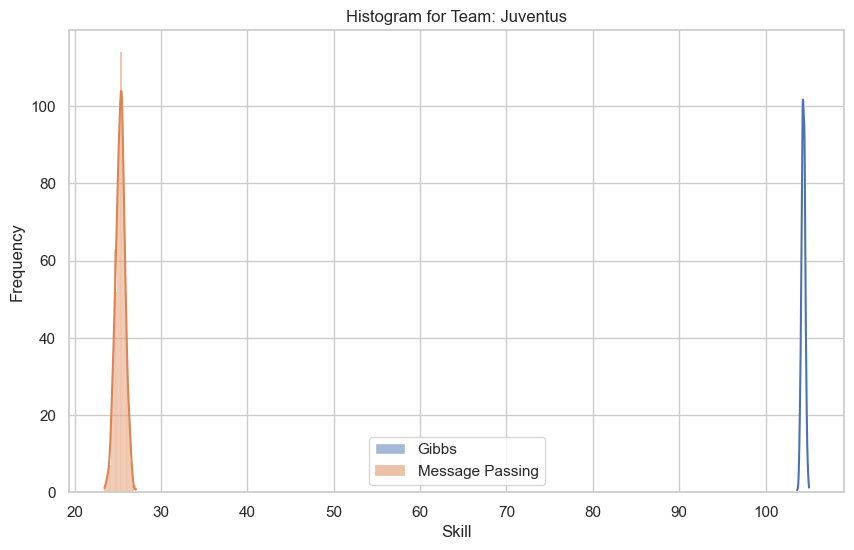

In [39]:
def sample_from_dataframe(dataframe, team_name, num_samples):
    team_data = dataframe[dataframe['team'] == team_name]
    mu = team_data['mu'].values[0]
    sigma = team_data['sigma'].values[0]
    samples = np.random.normal(mu, np.sqrt(sigma), num_samples)
    return samples

team_name = 'Juventus' 
num_samples_hist = 1000
samples_df = sample_from_dataframe(skills_df, team_name, num_samples_hist)

samples_df_FACTOR = sample_from_dataframe(skills_df_FACTOR, team_name, num_samples_hist)

plt.figure(figsize=(10, 6))
sns.histplot(samples_df, kde=True, label='Gibbs')
sns.histplot(samples_df_FACTOR, kde=True, label='Message Passing')

plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.title(f'Histogram for Team: {team_name}')
plt.legend()
plt.show()

c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

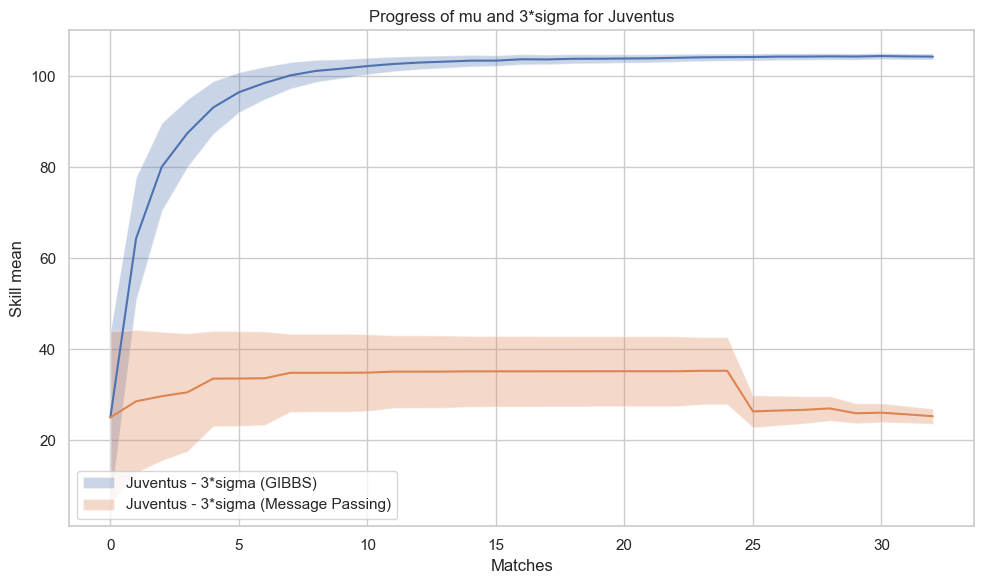

In [40]:
df_FACTOR = pd.DataFrame(skills_history_FACTOR[team_name], columns=["mu", "sigma"])
df = pd.DataFrame(skills_history[team_name], columns=["mu", "sigma"])
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x=df.index, y="mu")

sns.lineplot(data=df_FACTOR, x=df.index, y="mu")

alpha = 3
plt.fill_between(
    x=df.index,
    y1=df["mu"] - alpha * np.sqrt(df["sigma"]),
    y2=df["mu"] + alpha * np.sqrt(df["sigma"]),
    alpha=0.3,
    label=f"{team_name} - {alpha}*sigma (GIBBS)",
)

plt.fill_between(
    x=df.index,
    y1=df_FACTOR["mu"] - alpha * np.sqrt(df_FACTOR["sigma"]),
    y2=df_FACTOR["mu"] + alpha * np.sqrt(df_FACTOR["sigma"]),
    alpha=0.3,
    label=f"{team_name} - {alpha}*sigma (Message Passing)",
)

plt.xlabel("Matches")
plt.ylabel("Skill mean")
plt.title(f"Progress of mu and {alpha}*sigma for {team_name}")
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.show()

c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

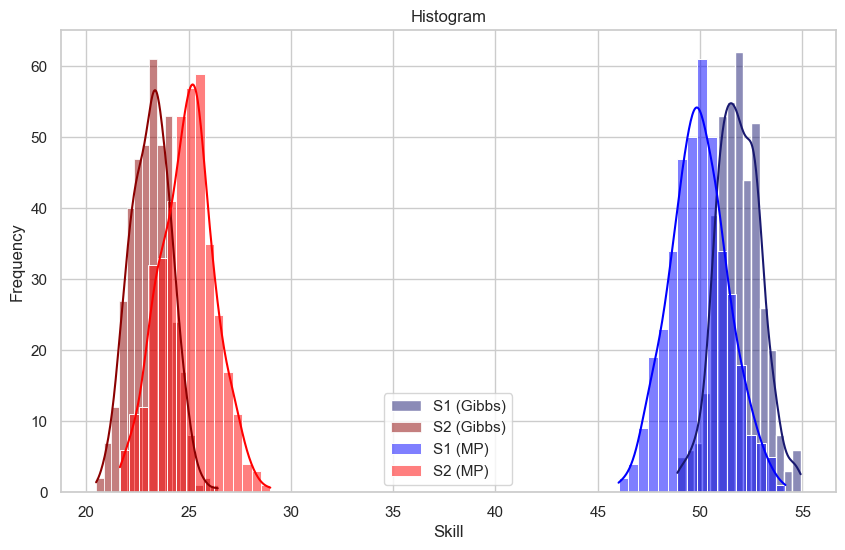

In [60]:
num_samples= 1000

mu1 = 50.0
sigma1 = 2.0

mu2 = 25.0
sigma2 = 2

beta_inv = 0.8
y= 1

s1 = np.random.normal(mu1, np.sqrt(sigma1))
s2 = np.random.normal(mu2, np.sqrt(sigma2))

mu1_gibbs, mu2_gibbs, sigma1_gibbs, sigma2_gibbs, _ = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))

mt, st = truncGaussMM(0, np.inf, mu1-mu2 , beta_inv + sigma1 + sigma2) if y==1 else  truncGaussMM(-np.inf, 0, mu1-mu2 , beta_inv + sigma1 + sigma2)
    
m6, s6 = divideGauss(mt , st , mu1-mu2 , beta_inv + sigma1 + sigma2)

m71, m72 = m6 + mu2, -m6 + mu1
s71, s72 = beta_inv + sigma2 + s6, beta_inv + sigma1 + s6

mu1_MP, sigma1_MP = mutiplyGauss(mu1, sigma1, m71, s71)
mu2_MP, sigma2_MP = mutiplyGauss(mu2, sigma2, m72, s72)

num_samples_hist = 400
S1_gibbs_samples = np.random.normal(mu1_gibbs, np.sqrt(sigma1_gibbs), num_samples_hist)
S2_gibbs_samples = np.random.normal(mu2_gibbs, np.sqrt(sigma2_gibbs), num_samples_hist)

S1_MP_samples = np.random.normal(mu1_MP, np.sqrt(sigma1_MP), num_samples_hist)
S2_MP_samples = np.random.normal(mu2_MP, np.sqrt(sigma2_MP), num_samples_hist)


plt.figure(figsize=(10, 6))
sns.histplot(S1_gibbs_samples, kde=True, label='S1 (Gibbs)', color = 'midnightblue')
sns.histplot(S2_gibbs_samples, kde=True, label='S2 (Gibbs)', color = 'darkred')
sns.histplot(S1_MP_samples, kde=True, label='S1 (MP)', color = 'blue')
sns.histplot(S2_MP_samples, kde=True, label='S2 (MP)', color = 'red')


plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.title(f'Histogram')
plt.legend()
plt.show()
